# requirements : pip install pandas, pip install -U scikit-learn


In [1]:
import os
import matplotlib.pyplot as plt

os.chdir("..")
from data_parser import ALL_CHAMPION_BASE_STATS

In [2]:
print(ALL_CHAMPION_BASE_STATS["Aatrox"])
print(type(ALL_CHAMPION_BASE_STATS))

{'health': 650, 'health_perlevel': 114, 'mana': 0, 'mana_perlevel': 0, 'move_speed': 345, 'armor': 38, 'armor_perlevel': 4.45, 'magic_resist': 32, 'magic_resist_perlevel': 2.05, 'attack_range': 175, 'health_regen': 3, 'health_regen_perlevel': 1, 'mana_regen': 0, 'mana_regen_perlevel': 0, 'crit_chance': 0, 'crit_chance_perlevel': 0, 'attack_damage': 60, 'attack_damage_perlevel': 5, 'attack_speed_perlevel': 2.5, 'attack_speed': 0.651}
<class 'dict'>


In [3]:
import pandas as pd

In [4]:
df = pd.DataFrame.from_dict(ALL_CHAMPION_BASE_STATS)
df = pd.DataFrame.transpose(df)
df.head()

,health,health_perlevel,mana,mana_perlevel,move_speed,armor,armor_perlevel,magic_resist,magic_resist_perlevel,attack_range,health_regen,health_regen_perlevel,mana_regen,mana_regen_perlevel,crit_chance,crit_chance_perlevel,attack_damage,attack_damage_perlevel,attack_speed_perlevel,attack_speed
Aatrox,650.0,114.0,0.0,0.0,345.0,38.0,4.45,32.0,2.05,175.0,3.00,1.00,0.0,0.0,0.0,0.0,60.0,5.00,2.500,0.651
Ahri,570.0,96.0,418.0,25.0,330.0,18.0,4.70,30.0,1.30,550.0,2.50,0.60,8.0,0.8,0.0,0.0,53.0,3.00,2.000,0.668
Akali,570.0,119.0,200.0,0.0,345.0,23.0,4.70,37.0,2.05,125.0,9.00,0.90,50.0,0.0,0.0,0.0,62.0,3.30,3.200,0.625
Akshan,630.0,104.0,350.0,40.0,330.0,26.0,4.20,30.0,1.30,500.0,3.75,0.65,8.2,0.7,0.0,0.0,52.0,3.50,4.000,0.638
Alistar,670.0,120.0,350.0,40.0,330.0,44.0,4.70,32.0,2.05,125.0,8.50,0.85,8.5,0.8,0.0,0.0,62.0,3.75,2.125,0.625


stats @ level is equal to base_stat + stat_perlevel*level\
for attack speed, increase is (base + mean_growth_perlevel * (level - 1) * (0.7025 + 0.0175 * (level - 1))) / 100

In [5]:
level = 18
df["max_health"] = df["health"] + df["health_perlevel"] * (level - 1) * (0.7025 + 0.0175 * (level - 1))
df["max_mana"] = df["mana"] + df["mana_perlevel"] * (level - 1) * (0.7025 + 0.0175 * (level - 1))
df["max_armor"] = df["armor"] + df["armor_perlevel"] * (level - 1) * (0.7025 + 0.0175 * (level - 1))
df["max_magic_resist"] = df["magic_resist"] + df["magic_resist_perlevel"] * (level - 1) * (0.7025 + 0.0175 * (level - 1))
df["max_attack_damage"] = df["attack_damage"] + df["attack_damage_perlevel"] * (level - 1) * (0.7025 + 0.0175 * (level - 1))
df["max_attack_speed"] = df["attack_speed"] * (
    1 + df["attack_speed_perlevel"] * (level - 1) * (0.7025 + 0.0175 * (level - 1))/100
)

In [6]:
from champions import Ahri

ahri = Ahri(level=18)
assert ahri.orig_base_stats.attack_speed == df.at["Ahri","max_attack_speed"]
assert ahri.orig_base_stats.health == df.at["Ahri","max_health"]
print("check passed")

check passed


In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


In [8]:
df["base_max_dps"] = df["max_attack_damage"] * df["max_attack_speed"]
df["base_max_physical_effective_health"] = df["max_health"] * df["max_armor"]/100
df["base_max_magical_effective_health"] = df["max_health"] * df["max_magic_resist"]/100

In [30]:
scaler = MinMaxScaler()

scaler.fit(df[["max_health"]])
df["max_health"] = scaler.transform(df[["max_health"]])

scaler.fit(df[["max_mana"]])
df["max_mana"] = scaler.transform(df[["max_mana"]])

scaler.fit(df[["max_armor"]])
df["max_armor"] = scaler.transform(df[["max_armor"]])

scaler.fit(df[["max_magic_resist"]])
df["max_magic_resist"] = scaler.transform(df[["max_magic_resist"]])

scaler.fit(df[["max_attack_damage"]])
df["max_attack_damage"] = 0.3 * scaler.transform(df[["max_attack_damage"]])

scaler.fit(df[["max_attack_speed"]])
df["max_attack_speed"] = scaler.transform(df[["max_attack_speed"]])

scaler.fit(df[["attack_range"]])
df["attack_range"] = 0.7 * scaler.transform(df[["attack_range"]])

scaler.fit(df[["base_max_dps"]])
df["base_max_dps"] = scaler.transform(df[["base_max_dps"]])

scaler.fit(df[["base_max_physical_effective_health"]])
df["base_max_physical_effective_health"] = scaler.transform(df[["base_max_physical_effective_health"]])

scaler.fit(df[["base_max_magical_effective_health"]])
df["base_max_magical_effective_health"] = scaler.transform(df[["base_max_magical_effective_health"]])




[15.889209592278426, 5.31632065442593, 3.524385118640304, 2.1398226852036517, 1.7690725442355761, 1.4461348885509142, 1.2466843189909649, 1.0947805896423135, 0.9628637551532164, 0.8774448947432396, 0.803531707152581, 0.7407269959575189, 0.6808471738485155, 0.6388955825246732, 0.6162223415458127, 0.568281349124011, 0.5420104833375379, 0.5262581219937184, 0.49589819465090496, 0.4679690936085966, 0.448049933386267, 0.4331022999873916, 0.4137513678014416, 0.38919677314035955, 0.3746226193149154, 0.34779429631852116, 0.33228097365351267, 0.326437686735649, 0.31570686920593805]


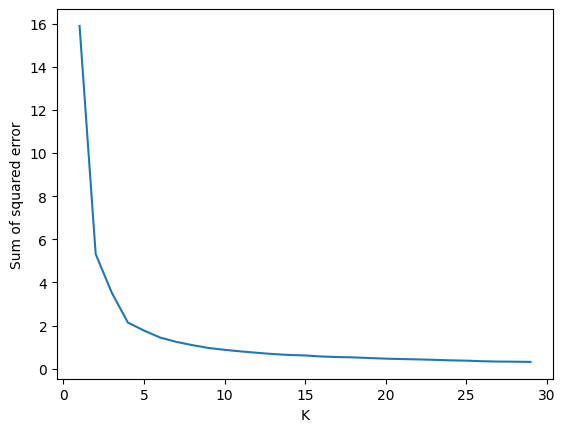

In [10]:
k_range = range(1,30)
sse =[]
for k in k_range:
    km = KMeans(n_clusters=k)
    #km.fit(df[["max_health","max_mana", "max_armor", "max_magic_resist", "max_attack_damage", "max_attack_speed"]])
    km.fit(df[["max_attack_speed", "max_attack_damage", "attack_range"]])
    sse.append(km.inertia_)

plt.xlabel("K")
plt.ylabel("Sum of squared error")
plt.plot(k_range,sse)
print(sse)

In [11]:
km = KMeans(n_clusters=6)

prediction = km.fit_predict(df[["max_attack_speed", "max_attack_damage", "attack_range"]])

df["cluster"] = prediction

df2 = df[["base_max_dps", "max_attack_damage", "max_attack_speed", "attack_range", "cluster"]]


In [12]:
pd.set_option("display.max_rows", None)
df2.loc[df["cluster"] == 0]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Aatrox,0.810194,0.276699,0.474784,0.066667,0
Akali,0.607219,0.198350,0.533333,0.000000,0
Amumu,0.653293,0.196893,0.601979,0.000000,0
Camille,0.637253,0.225728,0.459137,0.000000,0
Evelynn,0.482813,0.180583,0.439402,0.000000,0
Fizz,0.563288,0.171845,0.595711,0.066667,0
Gangplank,0.806171,0.238835,0.613258,0.000000,0
Garen,0.907134,0.269417,0.608333,0.066667,0
Gragas,0.591886,0.214078,0.447431,0.000000,0
Gwen,0.555661,0.186408,0.515961,0.033333,0


In [13]:
df2.loc[df["cluster"] == 1]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Ahri,0.401008,0.157282,0.423718,0.566667,1
Aphelios,0.390797,0.163107,0.381929,0.566667,1
Azir,0.409948,0.144466,0.500000,0.533333,1
Bard,0.333535,0.154369,0.333333,0.500000,1
Corki,0.380862,0.153204,0.411699,0.566667,1
Ezreal,0.383192,0.152913,0.416667,0.566667,1
Fiddlesticks,0.320680,0.145777,0.351667,0.473333,1
Janna,0.441647,0.154369,0.500000,0.500000,1
Kaisa,0.254074,0.125243,0.338924,0.533333,1
Karma,0.401181,0.166311,0.383333,0.533333,1


In [14]:
df2.loc[df["cluster"] == 2]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Braum,0.591482,0.173010,0.630871,0.000000,2
DrMundo,0.819278,0.205340,0.782620,0.000000,2
Ekko,0.637804,0.171845,0.704264,0.000000,2
Fiora,0.787456,0.215825,0.690761,0.033333,2
Gnar,0.828343,0.168932,1.000000,0.066667,2
Kassadin,0.771863,0.219320,0.654996,0.033333,2
Malphite,0.972901,0.233010,0.841424,0.000000,2
Maokai,0.773405,0.204175,0.727843,0.000000,2
MonkeyKing,0.793690,0.225728,0.653961,0.066667,2
Nilah,0.437903,0.122330,0.670541,0.133333,2


In [15]:
df2.loc[df["cluster"] == 3]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Anivia,0.317990,0.161359,0.280000,0.633333,3
Annie,0.150730,0.131214,0.137827,0.666667,3
AurelionSol,0.328199,0.178835,0.226667,0.566667,3
Brand,0.302353,0.168932,0.226667,0.566667,3
Cassiopeia,0.315595,0.157282,0.293310,0.566667,3
Elise,0.330541,0.163107,0.291667,0.566667,3
Graves,0.401607,0.250485,0.094039,0.400000,3
Heimerdinger,0.255982,0.151165,0.226667,0.566667,3
Jhin,0.338969,0.258932,0.000000,0.566667,3
Jinx,0.325113,0.194563,0.166667,0.533333,3


In [16]:
df2.loc[df["cluster"] == 4]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Alistar,0.538257,0.220631,0.354167,0.000000,4
Belveth,0.227856,0.113301,0.352941,0.066667,4
Blitzcrank,0.411416,0.208252,0.235082,0.000000,4
Chogath,0.560440,0.263301,0.240000,0.000000,4
Darius,0.557724,0.288350,0.166667,0.066667,4
Diana,0.403243,0.168932,0.375000,0.033333,4
Galio,0.399585,0.199515,0.250000,0.033333,4
Kayle,0.198118,0.123786,0.250000,0.066667,4
Mordekaiser,0.413245,0.230097,0.166667,0.066667,4
Nautilus,0.436912,0.195437,0.315325,0.066667,4


In [17]:
df2.loc[df["cluster"] == 5]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Akshan,0.661984,0.179126,0.700925,0.500000,5
Ashe,0.592518,0.172282,0.636069,0.633333,5
Caitlyn,0.912220,0.223107,0.814243,0.700000,5
Draven,0.687069,0.213204,0.573586,0.566667,5
Ivern,0.495321,0.148544,0.613697,0.466667,5
Kalista,1.000000,0.219903,0.941035,0.533333,5
Kennen,0.570143,0.179854,0.566667,0.566667,5
Kindred,0.540019,0.167476,0.583333,0.500000,5
KogMaw,0.564805,0.185534,0.532678,0.500000,5
Lucian,0.556712,0.172718,0.581832,0.500000,5


[8.00824226971963, 2.7688171619476147, 2.044380314024237, 1.5582975816502889, 1.2209220198994697, 1.0361252829249543, 0.869921869495098, 0.736659161434147, 0.621865094350827, 0.5566552178867908, 0.47528848915505156, 0.4350179702516349, 0.3907559254688163, 0.34856336378588526, 0.319345105810111, 0.29445113432267417, 0.26312460080967554, 0.24867999674300523, 0.22459603907894204, 0.21832744476447272, 0.19877604850576078, 0.18035459495350048, 0.16745469655097417, 0.1605751884614252, 0.15449630951274354, 0.14655072627350918, 0.13844408206201178, 0.12950929756454949, 0.12409885575642651]


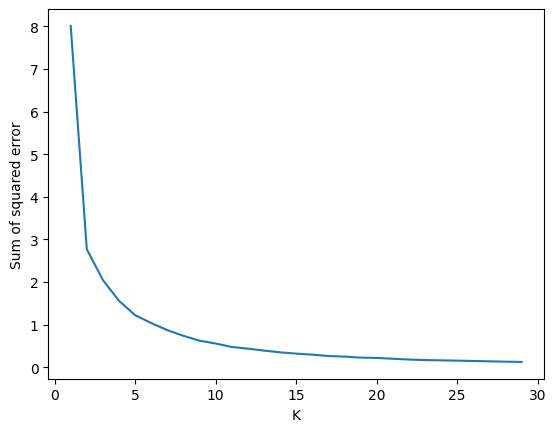

In [31]:
k_range = range(1,30)
sse =[]
for k in k_range:
    km = KMeans(n_clusters=k)
    #km.fit(df[["max_health","max_mana", "max_armor", "max_magic_resist", "max_attack_damage", "max_attack_speed"]])
    km.fit(df[["base_max_physical_effective_health", "base_max_magical_effective_health"]])
    sse.append(km.inertia_)

plt.xlabel("K")
plt.ylabel("Sum of squared error")
plt.plot(k_range,sse)
print(sse)

In [32]:
km = KMeans(n_clusters=5)

prediction = km.fit_predict(df[["base_max_physical_effective_health", "base_max_magical_effective_health"]])

df["cluster_tank"] = prediction

df_tank = df[["base_max_physical_effective_health", "base_max_magical_effective_health", "cluster_tank"]]

In [33]:
df_tank.loc[df["cluster_tank"] == 0]

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
Ahri,0.531590,0.231602,0
Anivia,0.618409,0.223070,0
Aphelios,0.568396,0.279381,0
Gnar,0.393194,0.095519,0
Heimerdinger,0.494379,0.262743,0
Janna,0.569861,0.144577,0
Kayle,0.539155,0.098917,0
Kled,0.573746,0.238104,0
KogMaw,0.589430,0.281087,0
Lulu,0.603805,0.184250,0


In [34]:
df_tank.loc[df["cluster_tank"] == 1]

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
Aatrox,0.826365,0.708827,1
Akali,0.723893,0.817721,1
Alistar,0.982638,0.775606,1
Blitzcrank,0.841170,0.571574,1
Braum,1.000000,0.668322,1
Darius,0.960861,0.709922,1
Galio,0.804196,0.810637,1
Gragas,0.854978,0.673248,1
Gwen,0.904924,0.645880,1
Illaoi,0.852461,0.665585,1


In [35]:
df_tank.loc[df["cluster_tank"] == 2]

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
Amumu,0.558990,0.495354,2
Belveth,0.685491,0.547354,2
Camille,0.771403,0.567059,2
Chogath,0.714556,0.519438,2
Diana,0.696504,0.656827,2
DrMundo,0.655421,0.608112,2
Ekko,0.629811,0.571985,2
Evelynn,0.735096,0.555564,2
Fiora,0.698333,0.552828,2
Fizz,0.640841,0.628912,2


In [36]:
df_tank.loc[df["cluster_tank"] == 3]

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
Akshan,0.599099,0.315214,3
Annie,0.660876,0.285353,3
Ashe,0.644259,0.297724,3
AurelionSol,0.646394,0.336118,3
Azir,0.619899,0.420583,3
Bard,0.816264,0.307962,3
Brand,0.611296,0.283646,3
Caitlyn,0.693993,0.315641,3
Cassiopeia,0.603598,0.354484,3
Corki,0.683465,0.304550,3


In [37]:
df_tank.loc[df["cluster_tank"] == 4]

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
Thresh,0.0,0.41845,4
